# News Classification Project - ML/DL with Reinforcement Learning

## Project Overview

This project implements a comprehensive news article classification system that combines classical machine learning, deep learning, and reinforcement learning techniques. The system classifies BBC news articles into categories, discovers latent topics through clustering, and uses a reinforcement learning agent to intelligently decide which model to use or when to escalate to human review.

### Key Components:
1. **News Article Classification** - Classify articles into 5 categories (business, entertainment, politics, sport, tech)
2. **Topic Discovery** - Group articles into topics using K-Means clustering
3. **Reinforcement Learning Agent** - Decide when to use classical ML, deep learning, or human escalation

## Dataset Overview

**Dataset:** BBC News Articles  
**Location:** `https://www.kaggle.com/datasets/pariza/bbc-news-summary`

The dataset contains BBC news articles organized into 5 categories:
- **Business** - Business and financial news
- **Entertainment** - Entertainment industry news
- **Politics** - Political news and analysis
- **Sport** - Sports news and updates
- **Tech** - Technology and innovation news

**Dataset Statistics:**
- Total articles: 2,225
- Categories: 5 (business, entertainment, politics, sport, tech)
- Format: Text files organized in category folders
- Balanced distribution across categories



___ 

## Part A. Data Mining and Pre-processing

### Step A1. Load Required Libraries and Dataset

In [3]:
# Required Libraries
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


### Step A1. Load Dataset

Load the BBC News Articles dataset


In [4]:
# Load dataset 
DATA_DIR = r"C:\INT_SYSTEMS\Final exam\FINAL_EXAM_INTELLIGENT_SYSTEM\qtn_3\review\News Articles"

categories = []
texts = []
filenames = []

for category in os.listdir(DATA_DIR):
    category_path = os.path.join(DATA_DIR, category)
    if not os.path.isdir(category_path):
        continue
    for fname in os.listdir(category_path):
        fpath = os.path.join(category_path, fname)
        if not os.path.isfile(fpath):
            continue
        with open(fpath, "r", encoding="latin-1") as f:
            text = f.read().strip()
        categories.append(category)
        texts.append(text)
        filenames.append(fname)

df = pd.DataFrame({
    "category": categories,
    "text": texts,
    "filename": filenames
})

print("Dataset shape:", df.shape)
print(f"Total articles: {len(df)}")
print(f"Categories: {df['category'].nunique()}")
print(f"\nCategories: {sorted(df['category'].unique())}")


Dataset shape: (2225, 3)
Total articles: 2225
Categories: 5

Categories: ['business', 'entertainment', 'politics', 'sport', 'tech']


### Step A2. Display Examples and Class Distribution

Dataset Shape: (2225, 4)
Rows: 2225, Columns: 4

Sample Articles (5 examples):

Label: business
Text Preview: UK house prices dip in November

UK house prices dipped slightly in November, the Office of the Deputy Prime Minister (ODPM) has said.

The average ho...
----------------------------------------------------------------------------------------------------

Label: business
Text Preview: LSE 'sets date for takeover deal'

The London Stock Exchange (LSE) is planning to announce a preferred takeover by the end of the month, newspaper rep...
----------------------------------------------------------------------------------------------------

Label: sport
Text Preview: Harinordoquy suffers France axe

Number eight Imanol Harinordoquy has been dropped from France's squad for the Six Nations match with Ireland in Dubli...
----------------------------------------------------------------------------------------------------

Label: business
Text Preview: Barclays shares up on merger talk



C:\Users\Thomas\AppData\Local\Temp\ipykernel_6200\3780421798.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


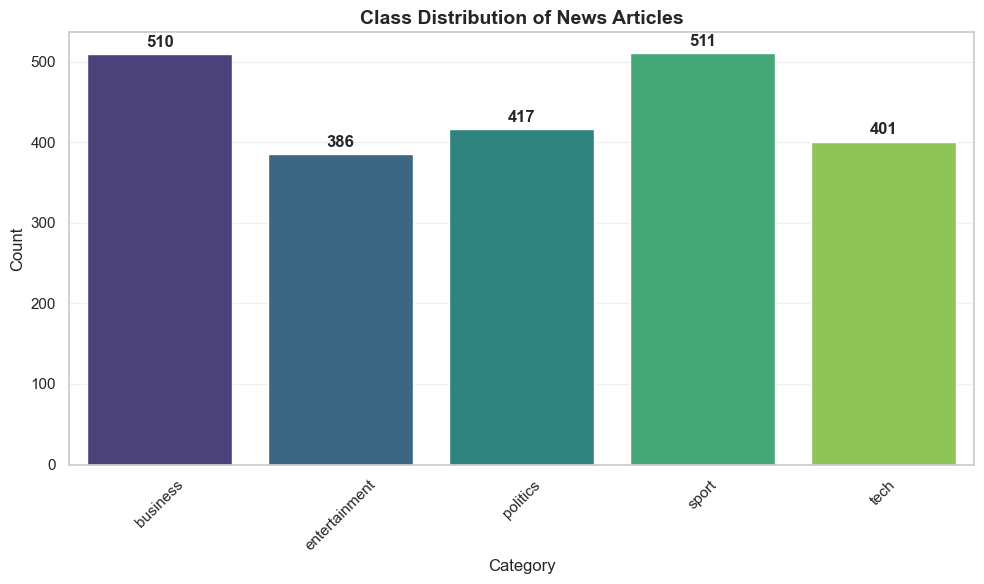

In [11]:
# 1. Print dataset shape
print("Dataset Shape:", df.shape)
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")

# 2. Display 5 sample articles with labels
print("Sample Articles (5 examples):")
print("=" * 100)
for idx, row in df.sample(5, random_state=RANDOM_STATE).iterrows():
    print(f"\nLabel: {row['category']}")
    print(f"Text Preview: {row['text'][:150]}...")
    print("-" * 100)

# 3. Plot class distribution using bar chart
print("\n\nClass Distribution:")
class_counts = df["category"].value_counts().sort_index()
print(class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution of News Articles", fontsize=14, fontweight='bold')
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


### Step A3. Clean Text Data

In [20]:
def clean_text(text):
    """Clean text data: lowercase, remove HTML, punctuation, numbers, extra whitespace"""
    
    text = text.lower()
    
    
    text = re.sub(r"<.*?>", " ", text)
    
    
    text = re.sub(r"\d+", " ", text)  # Remove digits
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    
    
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


df["clean_text"] = df["text"].apply(clean_text)

print("Text cleaning completed!")
print(f"Original text sample: {df['text'].iloc[0][:100]}...")
print(f"Cleaned text sample: {df['clean_text'].iloc[0][:100]}...")
print(f"\nCleaned dataset shape: {df.shape}")


Text cleaning completed!
Original text sample: Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.1...
Cleaned text sample: ad sales boost time warner profit quarterly profits at us media giant timewarner jumped to bn â£ m f...

Cleaned dataset shape: (2225, 4)


### Step A4. Prepare Features

#### A4.1. Create TF-IDF Features


In [21]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

# Fit on full dataset, (will be splitted later)
X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["category"]

print("TF-IDF Features Created")
print(f"TF-IDF shape: {X_tfidf.shape}")
print(f"Number of features: {X_tfidf.shape[1]}")


TF-IDF Features Created
TF-IDF shape: (2225, 5000)
Number of features: 5000


#### A4.2. Prepare Tokenized Sequences for Deep Learning

In [22]:
# Parameters for tokenization
MAX_NUM_WORDS = 10000
MAX_SEQ_LEN = 300

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

sequences = tokenizer.texts_to_sequences(df["clean_text"])

X_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

word_index = tokenizer.word_index
print("Tokenization Completed")
print(f"Vocabulary size: {len(word_index)}")
print(f"Sequence tensor shape: {X_seq.shape}")
print(f"Max sequence length: {MAX_SEQ_LEN}")


Tokenization Completed
Vocabulary size: 31519
Sequence tensor shape: (2225, 300)
Max sequence length: 300


#### A4.3. Train/Test Split

In [24]:
# Encode labels
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)


indices = np.arange(len(y_int))
X_tfidf_train, X_tfidf_test, X_seq_train, X_seq_test, y_train_int, y_test_int, train_idx, test_idx = train_test_split(
    X_tfidf, X_seq, y_int, indices,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_int
)


y_train_cat = to_categorical(y_train_int, num_classes=num_classes)
y_test_cat = to_categorical(y_test_int, num_classes=num_classes)

print("Train/Test Split Completed")
print(f"Training size: {X_tfidf_train.shape[0]} ({X_tfidf_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test size: {X_tfidf_test.shape[0]} ({X_tfidf_test.shape[0]/len(df)*100:.1f}%)")
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")


Train/Test Split Completed
Training size: 1780 (80.0%)
Test size: 445 (20.0%)
Number of classes: 5
Classes: ['business' 'entertainment' 'politics' 'sport' 'tech']


## Part B. Two News Classifiers

### Step B1. Train Classical ML Model(Logistic Regression)

In [25]:
# Train Logistic Regression model
ml_model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, n_jobs=-1)

print("Training Classical ML Model (Logistic Regression)...")
ml_model.fit(X_tfidf_train, y_train_int)


y_ml_pred = ml_model.predict(X_tfidf_test)


y_ml_prob = ml_model.predict_proba(X_tfidf_test)

print("\nClassical ML Model Training Completed!")
print("\nClassification Report:")
print(classification_report(y_test_int, y_ml_pred, target_names=label_encoder.classes_))

Training Classical ML Model (Logistic Regression)...


c:\INT_SYSTEMS\Individual_Assgnment\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



Classical ML Model Training Completed!

Classification Report:
               precision    recall  f1-score   support

     business       1.00      0.96      0.98       102
entertainment       1.00      1.00      1.00        77
     politics       0.99      0.99      0.99        84
        sport       0.99      1.00      1.00       102
         tech       0.96      1.00      0.98        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



### Step B2. Evaluate Classical ML Model


F1 Scores per Class (ML Model):
  business: 0.9800
  entertainment: 1.0000
  politics: 0.9881
  sport: 0.9951
  tech: 0.9816

Macro F1 Score: 0.9890
Weighted F1 Score: 0.9887


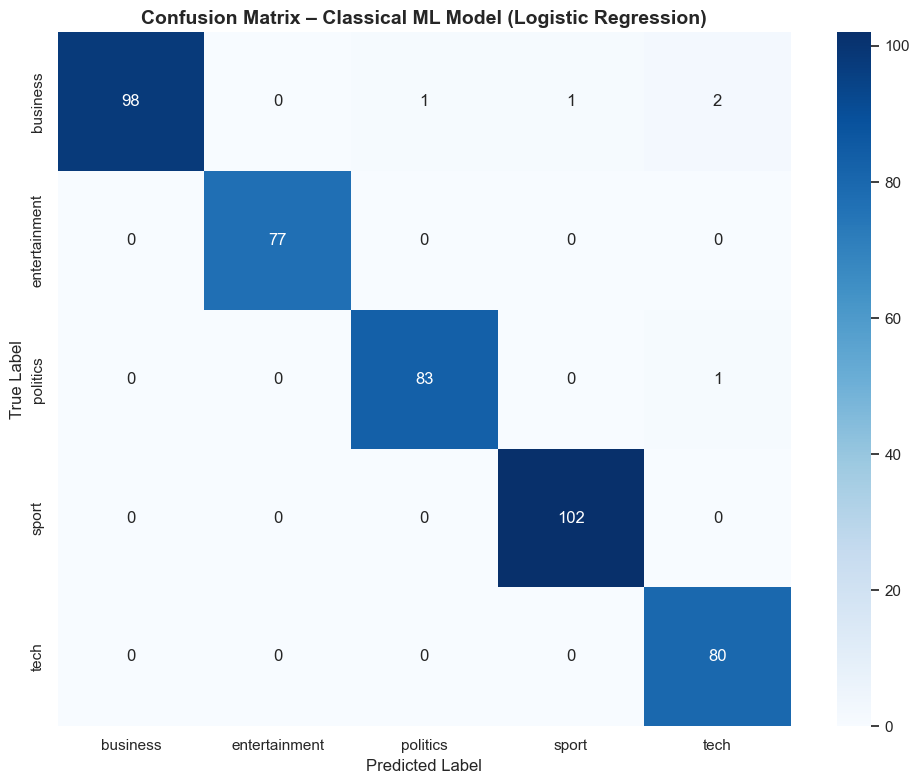

In [27]:

f1_scores_ml = f1_score(y_test_int, y_ml_pred, average=None)
print("F1 Scores per Class (ML Model):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {f1_scores_ml[i]:.4f}")
print(f"\nMacro F1 Score: {f1_score(y_test_int, y_ml_pred, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test_int, y_ml_pred, average='weighted'):.4f}")


cm_ml = confusion_matrix(y_test_int, y_ml_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ml, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix – Classical ML Model (Logistic Regression)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


5 misclassified examples

In [31]:

mis_idx = np.where(y_ml_pred != y_test_int)[0]
print(f"\nTotal misclassified articles (ML): {len(mis_idx)}")
print(f"Accuracy: {(1 - len(mis_idx)/len(y_test_int))*100:.2f}%\n")

if len(mis_idx) > 0:
    print("_" * 120)
    print("Five Misclassified Examples:")

    
    for count, i in enumerate(mis_idx[:5], 1):
        true_label = label_encoder.inverse_transform([y_test_int[i]])[0]
        pred_label = label_encoder.inverse_transform([y_ml_pred[i]])[0]
        original_idx = test_idx[i]
        text_snippet = df.iloc[original_idx]["text"]
        
        print(f"\nExample {count}:")
        print(f"  True Label: {true_label}")
        print(f"  Predicted Label: {pred_label}")
        print(f"  Text Snippet: {text_snippet[:200]}...")
        print("-" * 120)
else:
    print("No misclassified examples found!")



Total misclassified articles (ML): 5
Accuracy: 98.88%

________________________________________________________________________________________________________________________
Five Misclassified Examples:

Example 1:
  True Label: business
  Predicted Label: tech
  Text Snippet: Card fraudsters 'targeting web'

New safeguards on credit and debit card payments in shops has led fraudsters to focus on internet and phone payments, an anti-fraud agency has said.

Anti-fraud consul...
------------------------------------------------------------------------------------------------------------------------

Example 2:
  True Label: politics
  Predicted Label: tech
  Text Snippet: UK firms 'embracing e-commerce'

UK firms are embracing internet trading opportunities as never before, e-commerce minister Mike O'Brien says.

A government-commissioned study ranked the UK third in i...
-------------------------------------------------------------------------------------------------------------------

### Step B3. Train Deep Learning Model

In [35]:
# Train Deep Learning model (CNN)

EMBEDDING_DIM = 100

dl_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

dl_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Build the model to see parameter count in summary
dl_model.build(input_shape=(None, MAX_SEQ_LEN))
dl_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,709 (4.09 MB)

 Trainable params: 1,072,709 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

 3. Create validation set from training data


Training set size: 1424
Validation set size: 356
Test set size: 445

Training Deep Learning Model...
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2107 - loss: 1.6144 - val_accuracy: 0.2949 - val_loss: 1.5896
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2985 - loss: 1.5754 - val_accuracy: 0.4916 - val_loss: 1.5238
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4579 - loss: 1.3994 - val_accuracy: 0.5815 - val_loss: 1.1492
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6152 - loss: 1.0357 - val_accuracy: 0.8258 - val_loss: 0.7679
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7935 - loss: 0.6736 - val_accuracy: 0.8764 - val_loss: 0.4356
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8989 - loss: 0.3902 - val_accuracy: 0.8904 - val_loss: 0.2951
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9298 - loss: 0.2589 - val_accuracy: 0.9213 - val_loss: 0.2414
Epoch 8/20

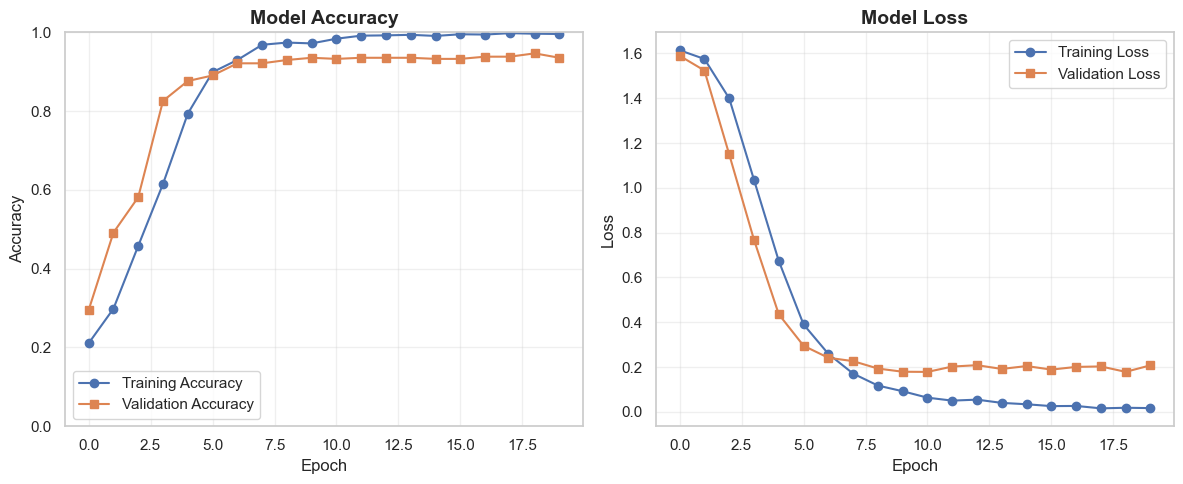

In [36]:

# Split training data into train and validation sets (80% train, 20% validation)
X_seq_train_final, X_seq_val, y_train_cat_final, y_val_cat = train_test_split(
    X_seq_train, y_train_cat,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=np.argmax(y_train_cat, axis=1)  # Stratify by class labels
)

print(f"Training set size: {X_seq_train_final.shape[0]}")
print(f"Validation set size: {X_seq_val.shape[0]}")
print(f"Test set size: {X_seq_test.shape[0]}")

# 4. Train model on tokenized sequences
EPOCHS = 20
BATCH_SIZE = 32

print("\nTraining Deep Learning Model...")
history = dl_model.fit(
    X_seq_train_final, y_train_cat_final,
    validation_data=(X_seq_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("\nDeep Learning Model Training Completed!")

# Plot training curves
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Step B4. Evaluate Deep Learning Model



F1 Scores per Class (DL Model):
  business: 0.9100
  entertainment: 0.9935
  politics: 0.9286
  sport: 0.9854
  tech: 0.9390

Macro F1 Score: 0.9513
Weighted F1 Score: 0.9504

Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.89      0.91       102
entertainment       1.00      0.99      0.99        77
     politics       0.93      0.93      0.93        84
        sport       0.98      0.99      0.99       102
         tech       0.92      0.96      0.94        80

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



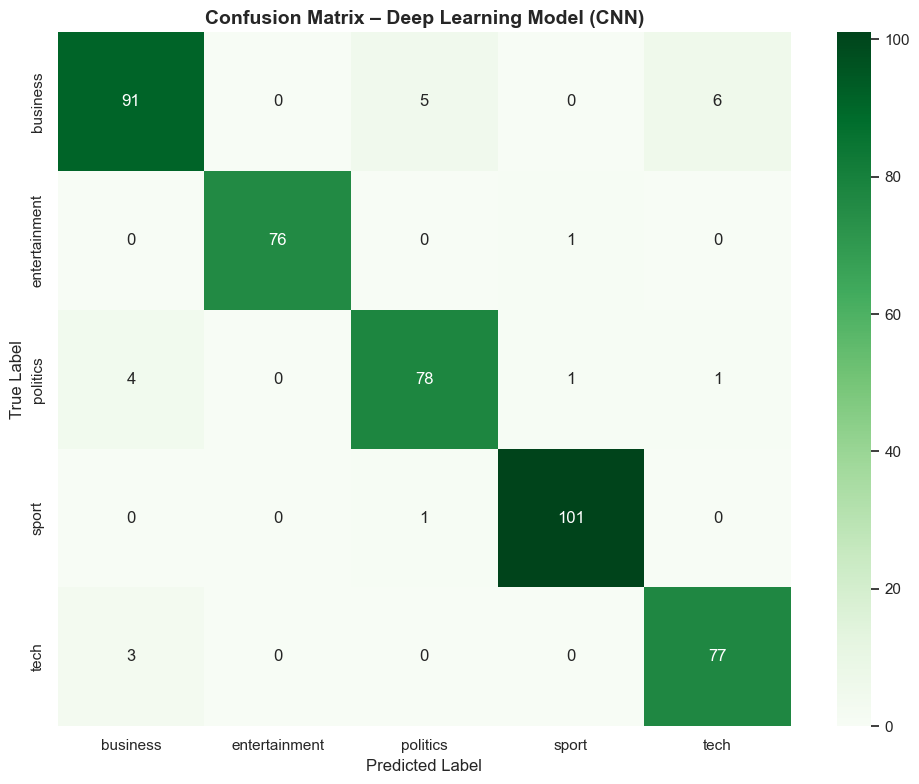


Total misclassified articles (DL): 22
Accuracy: 95.06%

Five Misclassified Examples:

Example 1:
  True Label: tech
  Predicted Label: business
  Text Snippet: New Year's texting breaks record

A mobile phone was as essential to the recent New Year's festivities as a party mood and Auld Lang Syne, if the number of text messages sent is anything to go by.

Be...
------------------------------------------------------------------------------------------------------------------------

Example 2:
  True Label: entertainment
  Predicted Label: sport
  Text Snippet: Famed music director Viotti dies

Conductor Marcello Viotti, director of Venice's famous La Fenice Theatre, has died in Germany at 50.

Viotti, director of La Fenice since 2002, conducted at renowned ...
------------------------------------------------------------------------------------------------------------------------

Example 3:
  True Label: tech
  Predicted Label: business
  Text Snippet: Junk e-mails on relentless rise



In [37]:

y_dl_prob = dl_model.predict(X_seq_test, verbose=0)
y_dl_pred = np.argmax(y_dl_prob, axis=1)


f1_scores_dl = f1_score(y_test_int, y_dl_pred, average=None)
print("F1 Scores per Class (DL Model):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {f1_scores_dl[i]:.4f}")
print(f"\nMacro F1 Score: {f1_score(y_test_int, y_dl_pred, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test_int, y_dl_pred, average='weighted'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_int, y_dl_pred, target_names=label_encoder.classes_))


cm_dl = confusion_matrix(y_test_int, y_dl_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix – Deep Learning Model (CNN)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

#  Extract five misclassified examples
mis_idx_dl = np.where(y_dl_pred != y_test_int)[0]
print(f"\nTotal misclassified articles (DL): {len(mis_idx_dl)}")
print(f"Accuracy: {(1 - len(mis_idx_dl)/len(y_test_int))*100:.2f}%\n")

if len(mis_idx_dl) > 0:
    print("=" * 120)
    print("Five Misclassified Examples:")
    print("=" * 120)
    
    for count, i in enumerate(mis_idx_dl[:5], 1):
        true_label = label_encoder.inverse_transform([y_test_int[i]])[0]
        pred_label = label_encoder.inverse_transform([y_dl_pred[i]])[0]
        original_idx = test_idx[i]
        text_snippet = df.iloc[original_idx]["text"]
        
        print(f"\nExample {count}:")
        print(f"  True Label: {true_label}")
        print(f"  Predicted Label: {pred_label}")
        print(f"  Text Snippet: {text_snippet[:200]}...")
        print("-" * 120)
else:
    print("No misclassified examples found!")


## Part C. Topic Clustering (TF-IDF)

### Step C1. Generate Document Embeddings

In [38]:

print("Using TF-IDF vectors for document embeddings")
print(f"TF-IDF shape: {X_tfidf.shape}")


USE_SVD = True
if USE_SVD:
    n_components = 100  # Reduce to 100 dimensions
    svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
    X_tfidf_reduced = svd.fit_transform(X_tfidf)
    print(f"Reduced TF-IDF shape (SVD): {X_tfidf_reduced.shape}")
    print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")
    X_clustering = X_tfidf_reduced
else:
    X_clustering = X_tfidf.toarray()
    print("Using full TF-IDF vectors (no dimensionality reduction)")


Using TF-IDF vectors for document embeddings
TF-IDF shape: (2225, 5000)
Reduced TF-IDF shape (SVD): (2225, 100)
Explained variance ratio: 0.2839


### Step C2. Apply Clustering Algorithm  (K-Means)


In [39]:


NUM_CLUSTERS = len(label_encoder.classes_)  # 5 clusters


kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_clustering)


df["cluster"] = clusters

print(f"Clustering Completed")
print(f"Number of clusters: {NUM_CLUSTERS}")
print(f"Cluster distribution:")
for i in range(NUM_CLUSTERS):
    count = np.sum(clusters == i)
    print(f"  Cluster {i}: {count} articles ({count/len(clusters)*100:.1f}%)")


Clustering Completed
Number of clusters: 5
Cluster distribution:
  Cluster 0: 295 articles (13.3%)
  Cluster 1: 379 articles (17.0%)
  Cluster 2: 126 articles (5.7%)
  Cluster 3: 939 articles (42.2%)
  Cluster 4: 486 articles (21.8%)


### Step C3. Visualize Clusters (PCA)


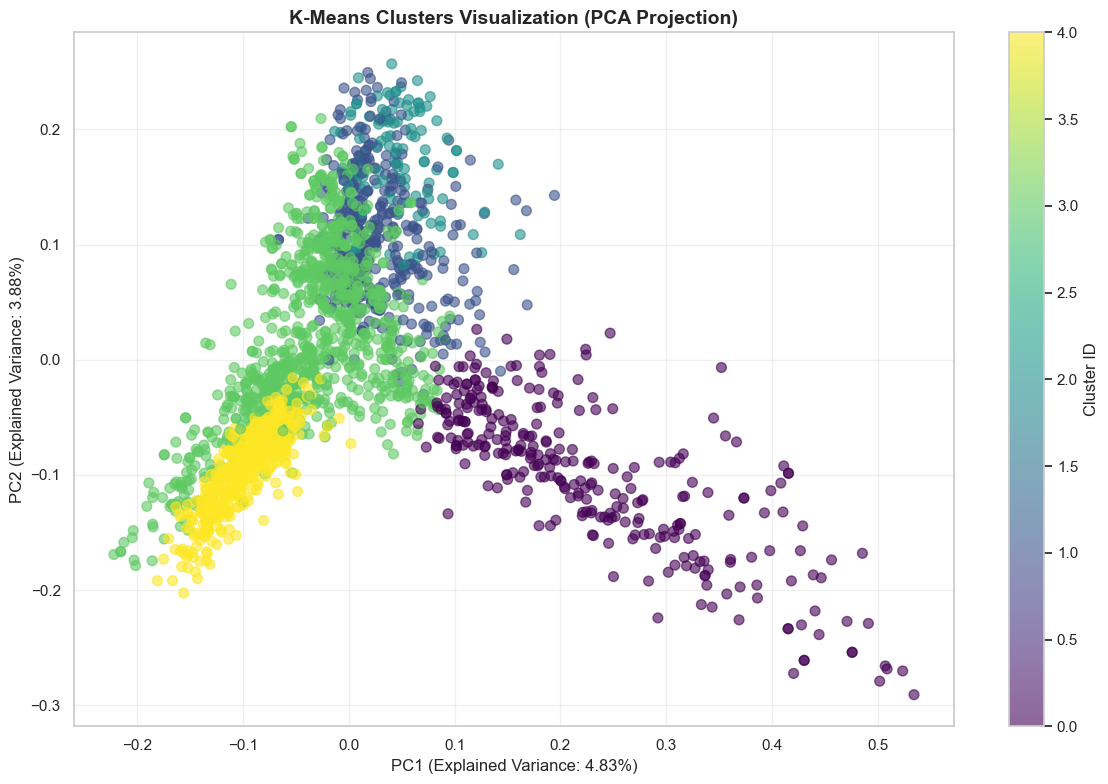


Cluster-Category Cross-tabulation:
category  business  entertainment  politics  sport  tech
cluster                                                 
0                4              0       291      0     0
1              351              3        20      1     4
2              126              0         0      0     0
3               28            383       106     30   392
4                1              0         0    480     5


In [ ]:

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_clustering)


plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster ID')
plt.title("K-Means Clusters Visualization (PCA Projection)", fontsize=14, fontweight='bold')
plt.xlabel(f"PC1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})", fontsize=12)
plt.ylabel(f"PC2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("\nCluster-Category Cross-tabulation:")
cluster_category = pd.crosstab(df['cluster'], df['category'])
print(cluster_category)


### Step C4. Extract Keywords per Cluster


In [42]:

if USE_SVD:
    
    centroids_original = svd.inverse_transform(kmeans.cluster_centers_)
else:
    centroids_original = kmeans.cluster_centers_


terms = np.array(tfidf_vectorizer.get_feature_names_out())
order_centroids = centroids_original.argsort()[:, ::-1]

TOP_N = 10
cluster_keywords = {}

print("Top Keywords per Cluster:")
print("-" * 100)
for i in range(NUM_CLUSTERS):
    top_terms = terms[order_centroids[i, :TOP_N]]
    cluster_keywords[i] = top_terms.tolist()
    print(f"\nCluster {i} ({np.sum(clusters == i)} articles):")
    print(f"  Top {TOP_N} keywords: {', '.join(top_terms)}")
    
    
    cluster_categories = df[df['cluster'] == i]['category'].value_counts()
    if len(cluster_categories) > 0:
        dominant_category = cluster_categories.index[0]
        print(f"  Dominant category: {dominant_category} ({cluster_categories[dominant_category]} articles)")
    


Top Keywords per Cluster:
----------------------------------------------------------------------------------------------------

Cluster 0 (295 articles):
  Top 10 keywords: mr, labour, election, said, blair, party, government, brown, mr blair, howard
  Dominant category: politics (291 articles)

Cluster 1 (379 articles):
  Top 10 keywords: bn, said, company, shares, mr, firm, market, year, yukos, deal
  Dominant category: business (351 articles)

Cluster 2 (126 articles):
  Top 10 keywords: growth, economy, economic, prices, dollar, said, rate, rates, oil, year
  Dominant category: business (126 articles)

Cluster 3 (939 articles):
  Top 10 keywords: said, film, people, music, new, best, mr, tv, mobile, uk
  Dominant category: tech (392 articles)

Cluster 4 (486 articles):
  Top 10 keywords: game, england, win, said, cup, players, match, play, injury, world
  Dominant category: sport (480 articles)


## Part D. Reinforcement Learning Decision Agent

### Step D1. Define State Space


In [43]:


ml_max_conf = y_ml_prob.max(axis=1)  # 1. ML confidence score
dl_max_conf = y_dl_prob.max(axis=1)  # 2. DL confidence score

ml_pred_labels = y_ml_pred
dl_pred_labels = y_dl_pred


if USE_SVD:
    X_tfidf_test_reduced = svd.transform(X_tfidf_test)
    clusters_test = kmeans.predict(X_tfidf_test_reduced)
else:
    clusters_test = kmeans.predict(X_tfidf_test.toarray())


lengths = np.sum(X_seq_test != 0, axis=1)

def bin_length(l):
    if l < 100:
        return 0  
    elif l < 200:
        return 1  
    else:
        return 2  

length_bins = np.array([bin_length(l) for l in lengths])

# 5. Disagreement flag (ML vs DL prediction differ)
disagreement = (ml_pred_labels != dl_pred_labels).astype(int)

# True labels (for reward calculation)
true_labels = y_test_int

print("State Space Components Created:")
print(f"  1. ML confidence score: shape {ml_max_conf.shape}, range [{ml_max_conf.min():.3f}, {ml_max_conf.max():.3f}]")
print(f"  2. DL confidence score: shape {dl_max_conf.shape}, range [{dl_max_conf.min():.3f}, {dl_max_conf.max():.3f}]")
print(f"  3. Cluster ID: shape {clusters_test.shape}, unique clusters {np.unique(clusters_test)}")
print(f"  4. Article length category: shape {length_bins.shape}, distribution {np.bincount(length_bins)}")
print(f"  5. Disagreement flag: shape {disagreement.shape}, disagreements {disagreement.sum()} ({disagreement.sum()/len(disagreement)*100:.1f}%)")
print(f"\nTotal samples for RL environment: {len(true_labels)}")


State Space Components Created:
  1. ML confidence score: shape (445,), range [0.258, 0.983]
  2. DL confidence score: shape (445,), range [0.330, 1.000]
  3. Cluster ID: shape (445,), unique clusters [0 1 2 3 4]
  4. Article length category: shape (445,), distribution [  1  49 395]
  5. Disagreement flag: shape (445,), disagreements 21 (4.7%)

Total samples for RL environment: 445


### Step D2. Define Action Space

- **0** = ML prediction
- **1** = DL prediction
- **2** = Escalate 


In [ ]:

def bin_conf(p):
    """Bin confidence scores into 5 categories"""
    if p < 0.2:
        return 0
    elif p < 0.4:
        return 1
    elif p < 0.6:
        return 2
    elif p < 0.8:
        return 3
    else:
        return 4

ml_conf_bins = np.array([bin_conf(p) for p in ml_max_conf])
dl_conf_bins = np.array([bin_conf(p) for p in dl_max_conf])


num_conf_bins = 5
num_length_bins = 3
num_clusters = NUM_CLUSTERS
num_disagree = 2
num_actions = 3  # 0=ML, 1=DL, 2=escalate

# Encode state as single integer
def encode_state(i):
    return (
        ml_conf_bins[i] * (num_conf_bins * num_length_bins * num_clusters * num_disagree) +
        dl_conf_bins[i] * (num_length_bins * num_clusters * num_disagree) +
        length_bins[i] * (num_clusters * num_disagree) +
        clusters_test[i] * num_disagree +
        disagreement[i]
    )

num_states = num_conf_bins**2 * num_length_bins * num_clusters * num_disagree
print(f"State space size: {num_states} states")
print(f"Action space: {num_actions} actions (0=ML, 1=DL, 2=Escalate)")


State space size: 750 states
Action space: 3 actions (0=ML, 1=DL, 2=Escalate)


### Step D3. Define Reward Function


In [36]:
def get_reward(i, action):
    """Reward function for RL agent"""
    true = true_labels[i]
    ml_correct = (ml_pred_labels[i] == true)
    dl_correct = (dl_pred_labels[i] == true)
    ml_conf = ml_max_conf[i]
    dl_conf = dl_max_conf[i]
    
    if action == 0:  # ML prediction
        if ml_correct:
            # Higher reward for high confidence correct predictions
            reward = 5 + 2 * ml_conf  # Base + confidence bonus
        else:
            reward = -5  # Wrong prediction penalty
    elif action == 1:  # DL prediction
        if dl_correct:
            # Higher reward for high confidence correct predictions
            reward = 6 + 2 * dl_conf  # Base + confidence bonus
        else:
            reward = -6  # Wrong prediction penalty
    else:  # Escalate to human
        if (not ml_correct) and (not dl_correct):
            reward = 2  # Good to escalate when both are wrong
        else:
            reward = -1  # Small penalty for escalation
    
    return reward

print("Reward Function Defined")
print("  - ML correct: +5 + (2 × confidence)")
print("  - ML wrong: -5")
print("  - DL correct: +6 + (2 × confidence)")
print("  - DL wrong: -6")
print("  - Escalate (both wrong): +2")
print("  - Escalate (otherwise): -1")


Reward Function Defined
  - ML correct: +5 + (2 × confidence)
  - ML wrong: -5
  - DL correct: +6 + (2 × confidence)
  - DL wrong: -6
  - Escalate (both wrong): +2
  - Escalate (otherwise): -1


### Step D4. Train Q-learning for 1000 -1500 episodes.

This step implements the Q-Learning algorithm to train the reinforcement learning agent.


#### Part 1: Initialize Q Table

Initialize the Q-table with zeros. The Q-table has dimensions (num_states × num_actions) where each entry Q[s, a] represents the expected cumulative reward for taking action `a` in state `s`.


#### Part 2: Set Q-Learning Parameters


In [37]:
# Set Q-Learning parameters
num_episodes = 1200  # Train for 1000-1500 episodes
alpha = 0.1          # Learning rate
gamma = 0.9          # Discount factor
epsilon = 0.2        # Exploration rate (epsilon-greedy)

print(f"Q-Learning Parameters:")
print(f"  Learning rate (α): {alpha}")
print(f"  Discount factor (γ): {gamma}")
print(f"  Exploration rate (ε): {epsilon}")
print(f"  Number of episodes: {num_episodes}")


Q-Learning Parameters:
  Learning rate (α): 0.1
  Discount factor (γ): 0.9
  Exploration rate (ε): 0.2
  Number of episodes: 1200


#### Part 3: Train Q-Learning Agent with Epsilon-Greedy Policy

In [38]:
# Initialize training tracking
rewards_per_episode = []
n_samples = len(true_labels)

print(f"\nTraining Q-Learning agent for {num_episodes} episodes...")
print("Using epsilon-greedy policy for action selection\n")

for ep in range(num_episodes):
    total_reward = 0.0
    indices = np.random.permutation(n_samples)  # Shuffle samples for each episode
    
    for idx in indices:
        s = encode_state(idx)
        
        # Epsilon-greedy policy: balance exploration and exploitation
        if np.random.rand() < epsilon:
            a = np.random.randint(num_actions)  # Explore: random action
        else:
            a = np.argmax(Q[s])  # Exploit: best known action
        
        # Get reward for chosen action
        r = get_reward(idx, a)
        total_reward += r
        
        # Update Q-value using Q-Learning update rule
        # Q[s, a] = Q[s, a] + α * (r + γ * max(Q[s_next]) - Q[s, a])
        s_next = s  # For this problem, next state is same as current state
        Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
    
    rewards_per_episode.append(total_reward)
    
    # Print progress every 200 episodes
    if (ep + 1) % 200 == 0:
        avg_reward = np.mean(rewards_per_episode[-200:])
        print(f"  Episode {ep + 1}/{num_episodes} - Average reward: {avg_reward:.2f}")

print("\nQ-Learning training completed!")



Training Q-Learning agent for 1200 episodes...
Using epsilon-greedy policy for action selection

  Episode 200/1200 - Average reward: 3144.10
  Episode 400/1200 - Average reward: 3137.99
  Episode 600/1200 - Average reward: 3142.64
  Episode 800/1200 - Average reward: 3137.13
  Episode 1000/1200 - Average reward: 3135.45
  Episode 1200/1200 - Average reward: 3140.33

Q-Learning training completed!


#### Part 4: Visualize Training Progress

Plot the reward progression over episodes to monitor the learning process. The moving average helps visualize the overall trend.


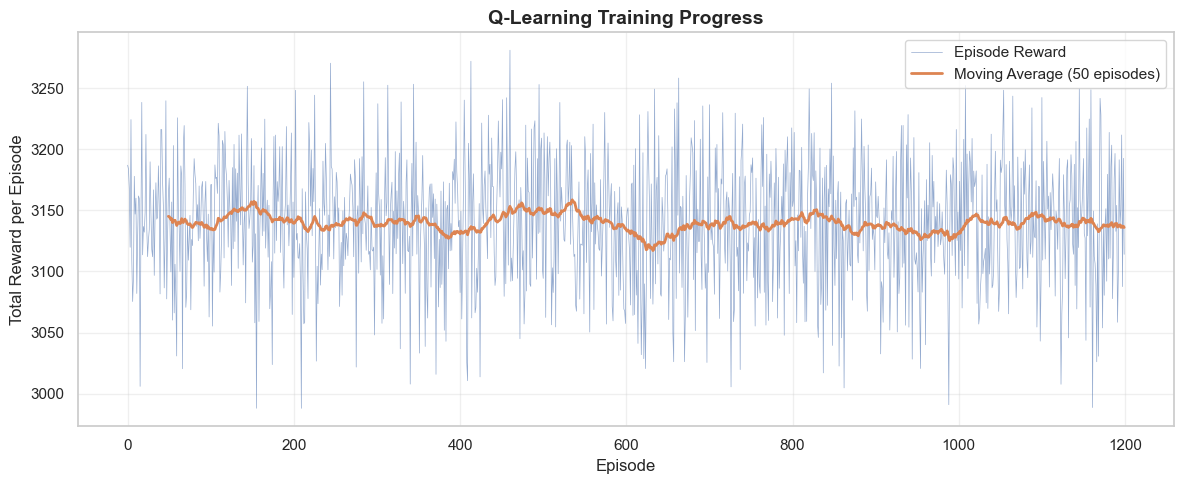

In [39]:
# Plot training progress
plt.figure(figsize=(12, 5))
plt.plot(rewards_per_episode, alpha=0.6, linewidth=0.5, label='Episode Reward')
plt.plot(pd.Series(rewards_per_episode).rolling(50).mean(), linewidth=2, label='Moving Average (50 episodes)')
plt.title("Q-Learning Training Progress", fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward per Episode", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Q-table initialized: (750, 3)

Training Q-Learning agent for 1200 episodes...
  Episode 200/1200 - Average reward: 3049.69
  Episode 400/1200 - Average reward: 3122.10
  Episode 600/1200 - Average reward: 3132.80
  Episode 800/1200 - Average reward: 3132.51
  Episode 1000/1200 - Average reward: 3142.45
  Episode 1200/1200 - Average reward: 3133.77
Q-Learning training completed!


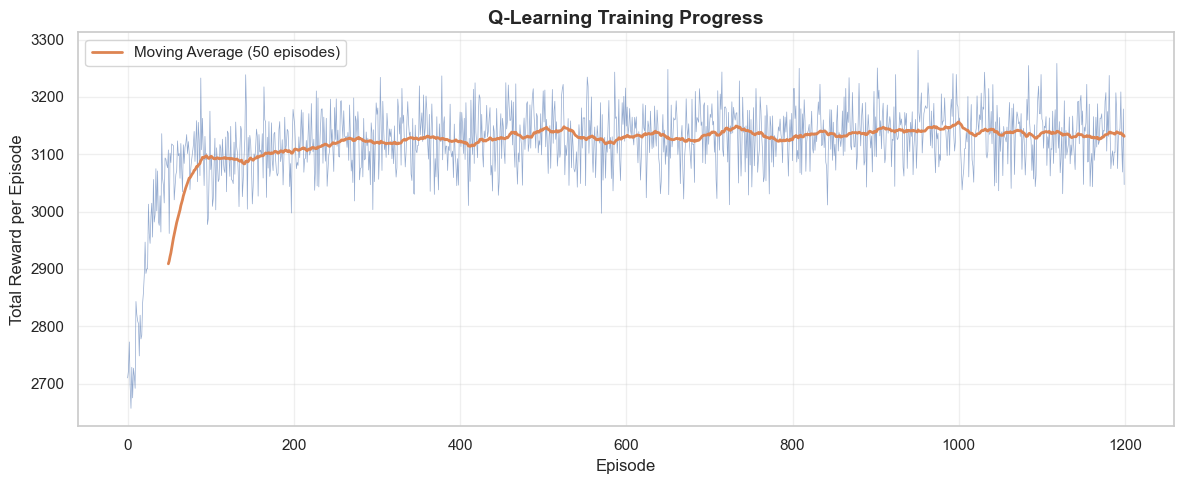

In [40]:
# 1. Initialize Q table
Q = np.zeros((num_states, num_actions))
print(f"Q-table initialized: {Q.shape}")

# 2. Q-Learning parameters
num_episodes = 1200  # Train for 1000-1500 episodes
alpha = 0.1          # Learning rate
gamma = 0.9          # Discount factor
epsilon = 0.2        # Exploration rate (epsilon-greedy)

# 3. Train Q-Learning agent
rewards_per_episode = []
n_samples = len(true_labels)

print(f"\nTraining Q-Learning agent for {num_episodes} episodes...")
for ep in range(num_episodes):
    total_reward = 0.0
    indices = np.random.permutation(n_samples)
    
    for idx in indices:
        s = encode_state(idx)
        
        # Epsilon-greedy policy
        if np.random.rand() < epsilon:
            a = np.random.randint(num_actions)  # Explore
        else:
            a = np.argmax(Q[s])  # Exploit
        
        # Get reward and next state
        r = get_reward(idx, a)
        total_reward += r
        
        # Update Q-value (simplified: next_state = current_state for this problem)
        s_next = s
        Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_next]) - Q[s, a])
    
    rewards_per_episode.append(total_reward)
    
    if (ep + 1) % 200 == 0:
        print(f"  Episode {ep + 1}/{num_episodes} - Average reward: {np.mean(rewards_per_episode[-200:]):.2f}")

print("Q-Learning training completed!")

# Plot training progress
plt.figure(figsize=(12, 5))
plt.plot(rewards_per_episode, alpha=0.6, linewidth=0.5)
plt.plot(pd.Series(rewards_per_episode).rolling(50).mean(), linewidth=2, label='Moving Average (50 episodes)')
plt.title("Q-Learning Training Progress", fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward per Episode", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Step D5. Evaluate RL Agent

Evaluate the trained RL agent and compare with ML and DL models.


Model Performance Comparison:
ML Model Accuracy:     0.9888 (98.88%)
DL Model Accuracy:     0.9506 (95.06%)
RL Agent Accuracy:     0.9910 (99.10%)

RL Action Distribution:
  Action 0 (Use ML): 18 times (4.0%)
  Action 1 (Use DL): 427 times (96.0%)


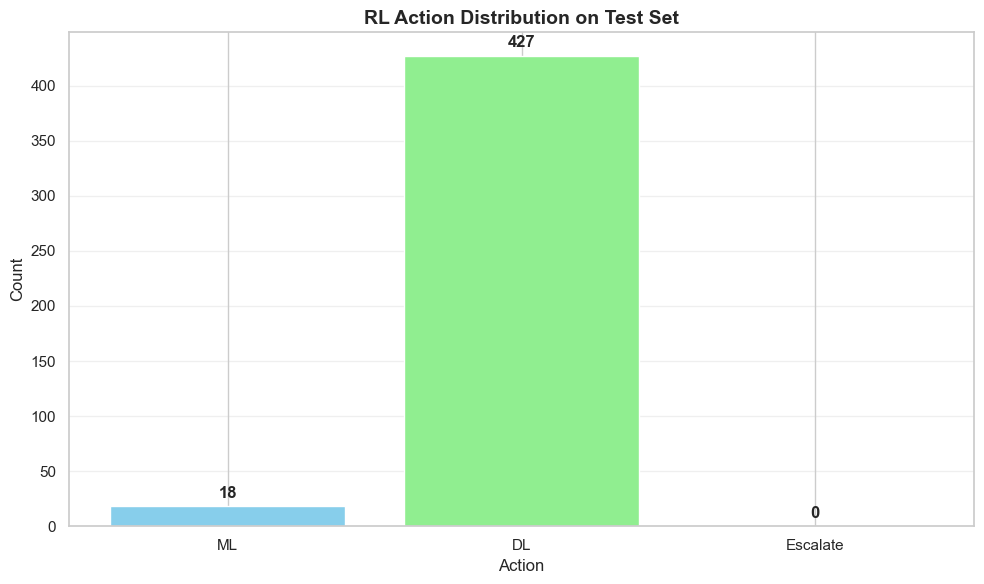

In [41]:
# Let RL agent choose actions for test samples
rl_actions = []
rl_preds = []

for i in range(n_samples):
    s = encode_state(i)
    a = np.argmax(Q[s])  # Choose best action according to Q-table
    rl_actions.append(a)
    
    if a == 0:  # ML
        rl_preds.append(ml_pred_labels[i])
    elif a == 1:  # DL
        rl_preds.append(dl_pred_labels[i])
    else:  # Escalate - use DL prediction as fallback
        rl_preds.append(dl_pred_labels[i])

rl_actions = np.array(rl_actions)
rl_preds = np.array(rl_preds)

# Accuracy comparison
acc_ml = accuracy_score(true_labels, ml_pred_labels)
acc_dl = accuracy_score(true_labels, dl_pred_labels)
acc_rl = accuracy_score(true_labels, rl_preds)

print("Model Performance Comparison:")
print("=" * 60)
print(f"ML Model Accuracy:     {acc_ml:.4f} ({acc_ml*100:.2f}%)")
print(f"DL Model Accuracy:     {acc_dl:.4f} ({acc_dl*100:.2f}%)")
print(f"RL Agent Accuracy:     {acc_rl:.4f} ({acc_rl*100:.2f}%)")
print("=" * 60)

# Action distribution
print("\nRL Action Distribution:")
unique, counts = np.unique(rl_actions, return_counts=True)
for a, c in zip(unique, counts):
    if a == 0:
        name = "Use ML"
    elif a == 1:
        name = "Use DL"
    else:
        name = "Escalate"
    print(f"  Action {a} ({name}): {c} times ({c/len(rl_actions)*100:.1f}%)")

plt.figure(figsize=(10, 6))
plt.bar(["ML", "DL", "Escalate"], 
        [np.sum(rl_actions==0), np.sum(rl_actions==1), np.sum(rl_actions==2)],
        color=['skyblue', 'lightgreen', 'salmon'])
plt.title("RL Action Distribution on Test Set", fontsize=14, fontweight='bold')
plt.ylabel("Count", fontsize=12)
plt.xlabel("Action", fontsize=12)
for i, v in enumerate([np.sum(rl_actions==0), np.sum(rl_actions==1), np.sum(rl_actions==2)]):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [47]:
# Q-table statistics
print("Q-Table Statistics:")
print("=" * 60)
print(f"Q-table shape: {Q.shape}")
print(f"Total states: {Q.shape[0]}, Total actions: {Q.shape[1]}\n")

print("Q-value Statistics:")
print(f"  Min Q-value:  {Q.min():.4f}")
print(f"  Max Q-value:  {Q.max():.4f}")
print(f"  Mean Q-value: {Q.mean():.4f}")
print(f"  Std Q-value:  {Q.std():.4f}\n")

# Count non-zero states
non_zero_states = np.where(np.abs(Q).sum(axis=1) > 0)[0]
print(f"States with non-zero Q-values: {len(non_zero_states)} / {Q.shape[0]} ({len(non_zero_states)/Q.shape[0]*100:.1f}%)\n")

# Show sample of learned Q-values
if len(non_zero_states) > 0:
    print("Sample of Learned Q-Values (first 10 non-zero states):")
    print("-" * 60)
    sample_states = non_zero_states[:10]
    for state in sample_states:
        best_action = np.argmax(Q[state])
        action_name = ["ML", "DL", "Escalate"][best_action]
        print(f"  State {state:3d}: ML={Q[state, 0]:7.2f}, DL={Q[state, 1]:7.2f}, Escalate={Q[state, 2]:7.2f} → Best: {action_name}")
else:
    print("No non-zero states found (all Q-values are zero)")


Q-Table Statistics:
Q-table shape: (750, 3)
Total states: 750, Total actions: 3

Q-value Statistics:
  Min Q-value:  0.0000
  Max Q-value:  79.9995
  Mean Q-value: 4.7046
  Std Q-value:  17.4830

States with non-zero Q-values: 52 / 750 (6.9%)

Sample of Learned Q-Values (first 10 non-zero states):
------------------------------------------------------------
  State 197: ML=  56.57, DL=  44.89, Escalate=  49.89 → Best: ML
  State 207: ML=  55.15, DL=  43.61, Escalate=  48.57 → Best: ML
  State 236: ML=  69.06, DL=  71.35, Escalate=  62.22 → Best: DL
  State 266: ML=  72.70, DL=  74.59, Escalate=  65.98 → Best: DL
  State 267: ML=  57.51, DL=  45.72, Escalate=  50.71 → Best: ML
  State 286: ML=  77.06, DL=  79.92, Escalate=  70.51 → Best: DL
  State 296: ML=  42.17, DL=  45.44, Escalate=  40.12 → Best: DL
  State 297: ML=  56.07, DL=  44.46, Escalate=  49.46 → Best: ML
  State 298: ML=  77.47, DL=  79.83, Escalate=  70.73 → Best: DL
  State 406: ML=  73.19, DL=  74.64, Escalate=  66.15 →

___